# Modelling Malaria Transmission using an SIS-SEI model, in the context of global warming
The below code implements the MacDonald system of ODEs for malaria. We altered the system to factor temperature into mosquito biting rate, death rate and latent period. We also factored in the death rate due to malaria for humans. The code was written following principles covered in class. The biggest hurdle we faced was the implementation of the delay differential equations, as they effectively required the system to have 'memory'. While a few libraries do exist for this purpose, none of them were working for us and we decided the best approach was to use interpolation. Numpy's built in interpolation function was used to estimate the values of the state variables at the time of the delay which were then utilised to solve the system. The code was tested with a variety of parameters and initial conditions, and the results were consistent with the expected behavior of the system. Finally, we graphed outputs for significant parameter values, with a focus on temperature and its effects on the peak, the day of the peak and the R0 value.

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [14]:
# Parameters and initial conditions. Ranges were taken from the Mathematical Models of Malaria paper, found in our references. 
b = 0.35  # Transmission probability per bite for mosquitoes to humans. range: 0.2-0.5
c = 0.5  # Transmission probability per bite for humans to mosquitoes. range: 0.5
m = 1 # Ratio of mosquitoes to humans. range: 0.5-40
r = 0.05  # Recovery rate of humans. range: 0.005-0.05
T = 28 #Temperature in degree celsius
mu_2 = 1/(-0.03*(T**2) + 1.31*T - 4.4) # Mortality rate of mosquitoes. The equation was determined by a study linked in the references of our report.
a = min(0.5,max(0, 0.017*T - 0.165)) #Biting rate is a linear function of temperature as found by regression analysis.
tau_m = (747.55* np.exp(-0.239*T)+5.06) #Latent period of mosquitoes, a function of temperature as found by regression analysis.
mu_3 = 20/10000 #Mortality rate of humans. range: 0.0001-0.004
R_0 = (m*(a**2)*b*c*np.exp(-mu_2*tau_m))/(r*mu_2) #Basic reproduction number

In [15]:
H0 = 0.05  # Initial proportion of infected humans
E_m0 = 0.05  # Initial proportion of exposed mosquitoes
I_m0 = 0.05  # Initial proportion of infectious mosquitoes
y0 = [H0, E_m0, I_m0]
t_span = (0, 500)  # Simulate over one year
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Daily time points

In [16]:
def macdonald_model(t, y, interp_H, interp_E_m, interp_I_m):
    H, E_m, I_m = y
    dHdt = a * b * m * I_m * (1 - H) - (r+mu_3) * H 

    if t >= tau_m:
        H_tau = interp_H(t - tau_m) # Interpolated value of H at t - tau_m
        E_m_tau = interp_E_m(t - tau_m) # Interpolated value of E_m at t - tau_m
        I_m_tau = interp_I_m(t - tau_m) # Interpolated value of I_m at t - tau_m
    else:
        H_tau, E_m_tau, I_m_tau = H0, E_m0, I_m0 # Assume initial conditions for t < tau_m

    dE_mdt = a * c * H * (1 - E_m - I_m) - mu_2 * E_m - a * c * H_tau * (1 - E_m_tau - I_m_tau) * np.exp(-mu_2 * tau_m) 
    dI_mdt = a * c * H_tau * (1 - E_m_tau - I_m_tau) * np.exp(-mu_2 * tau_m) - mu_2 * I_m

    return [dHdt, dE_mdt, dI_mdt]

In [17]:
#Initial solution for interpolation
initial_sol = solve_ivp(lambda t, y: macdonald_model(t, y, lambda x: H0, lambda x: E_m0, lambda x: I_m0), t_span, y0, t_eval=t_eval, method='RK45')
interp_H = interp1d(initial_sol.t, initial_sol.y[0], kind='linear', bounds_error=False, fill_value=(H0, initial_sol.y[0, -1]))
interp_E_m = interp1d(initial_sol.t, initial_sol.y[1], kind='linear', bounds_error=False, fill_value=(E_m0, initial_sol.y[1, -1]))
interp_I_m = interp1d(initial_sol.t, initial_sol.y[2], kind='linear', bounds_error=False, fill_value=(I_m0, initial_sol.y[2, -1]))

In [18]:
# Solving with interpolation
sol = solve_ivp(macdonald_model, t_span, y0, t_eval=t_eval, args=(interp_H, interp_E_m, interp_I_m), method='RK45')
peak_infected_humans = np.max(sol.y[0]) # Peak proportion of infected humans
peak_infected_day = np.argmax(sol.y[0]) # Day of peak proportion of infected humans

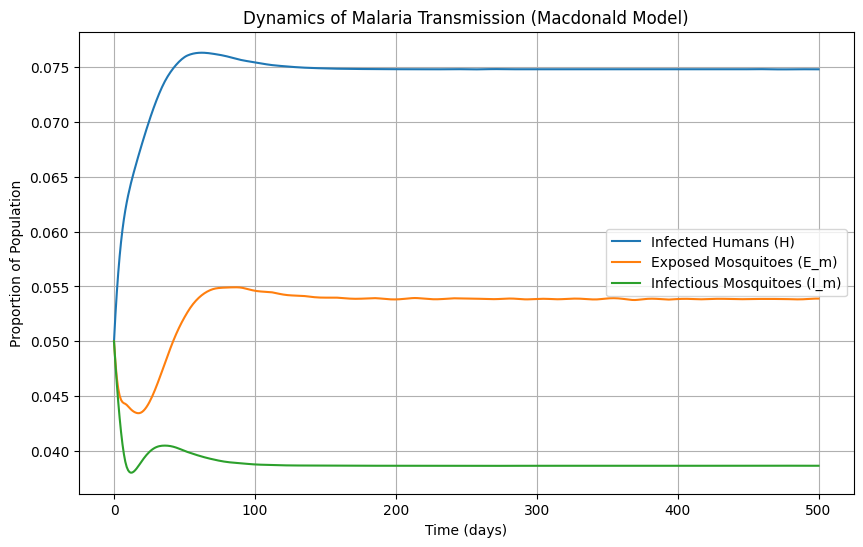

Basic reproduction number: 1.4970894123452025
Peak infected human proportion: 0.07633112103447147 on day 62


In [19]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='Infected Humans (H)')
plt.plot(sol.t, sol.y[1], label='Exposed Mosquitoes (E_m)')
plt.plot(sol.t, sol.y[2], label='Infectious Mosquitoes (I_m)')
plt.title('Dynamics of Malaria Transmission (Macdonald Model)')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)
plt.show()
print('Basic reproduction number:', R_0)
print('Peak infected human proportion:', peak_infected_humans, 'on day', peak_infected_day)

In [20]:
# Arrays to store results
temperatures = np.arange(14, 40)
peaks = []
peak_days = []
R_0array = []
mu_2array = []

In [21]:
for T in temperatures:
    tau_m = 747.55 * np.exp(-0.239 * T) + 5.06  # recalculate tau_m for each T
    a = max(0, 0.017 * T - 0.165)  # recalculate a for each T
    mu_2 = 1 / (-0.03 * (T ** 2) + 1.31 * T - 4.4)  # recalculate mu_2 for each T
    R_0 = (m * (a ** 2) * b * c * np.exp(-mu_2 * tau_m)) / (r * mu_2)  # recalculate R_0 for each T
    # Initial solution to set up interpolators
    initial_sol = solve_ivp(lambda t, y: macdonald_model(t, y, lambda x: H0, lambda x: E_m0, lambda x: I_m0),
                            t_span, y0, t_eval=t_eval, method='RK45')
    interp_H = interp1d(initial_sol.t, initial_sol.y[0], kind='linear', bounds_error=False, fill_value=(H0, initial_sol.y[0, -1]))
    interp_E_m = interp1d(initial_sol.t, initial_sol.y[1], kind='linear', bounds_error=False, fill_value=(E_m0, initial_sol.y[1, -1]))
    interp_I_m = interp1d(initial_sol.t, initial_sol.y[2], kind='linear', bounds_error=False, fill_value=(I_m0, initial_sol.y[2, -1]))
    # Solving with interpolation
    sol = solve_ivp(macdonald_model, t_span, y0, t_eval=t_eval, args=(interp_H, interp_E_m, interp_I_m), method='RK45')
    peak_infected_humans = np.max(sol.y[0])
    peak_infected_day = np.argmax(sol.y[0])
    peaks.append(peak_infected_humans)
    peak_days.append(peak_infected_day)
    R_0array.append(R_0)
    mu_2array.append(mu_2)

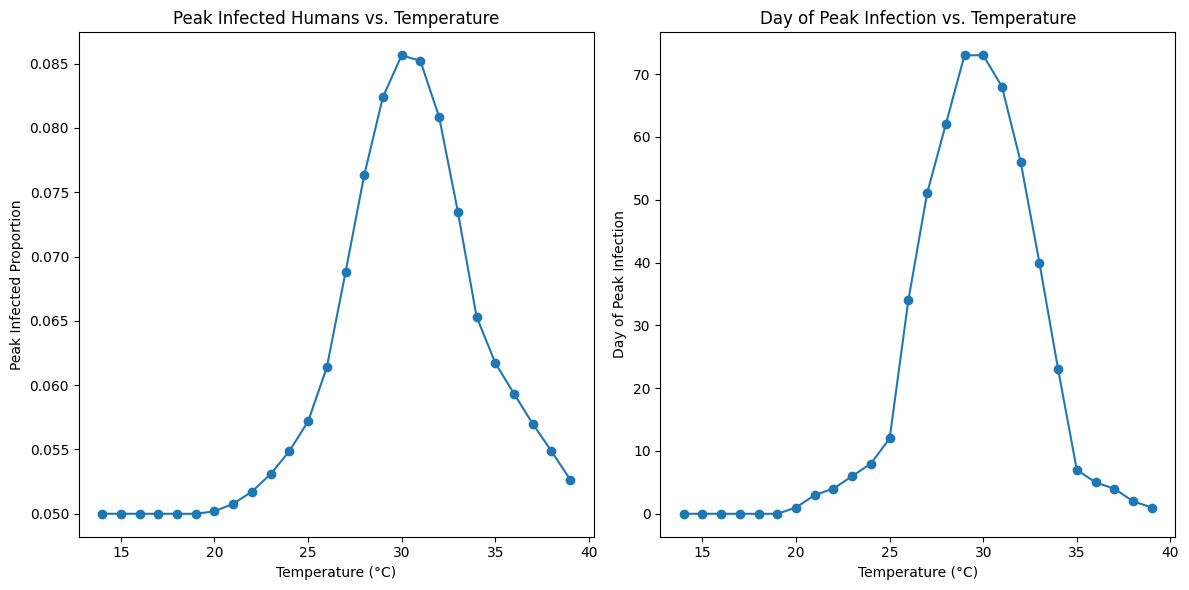

In [22]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(temperatures, peaks, '-o')
plt.title('Peak Infected Humans vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Peak Infected Proportion')

plt.subplot(1, 2, 2)
plt.plot(temperatures, peak_days, '-o')
plt.title('Day of Peak Infection vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Day of Peak Infection')
plt.tight_layout()
plt.show()

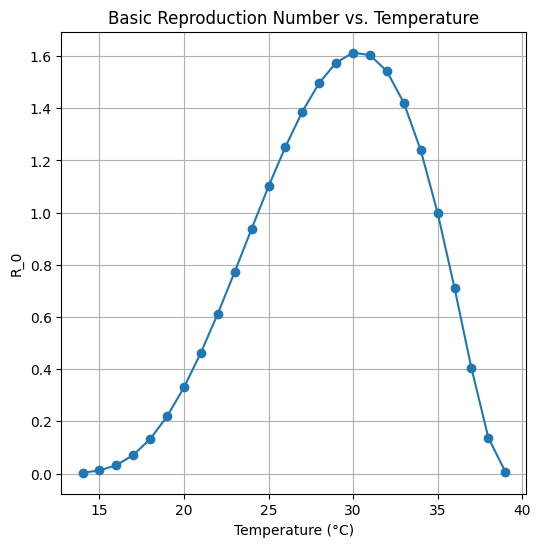

In [23]:
plt.figure(figsize=(6, 6))
plt.plot(temperatures, R_0array, '-o')
plt.title('Basic Reproduction Number vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('R_0')
plt.grid(True)
plt.show()

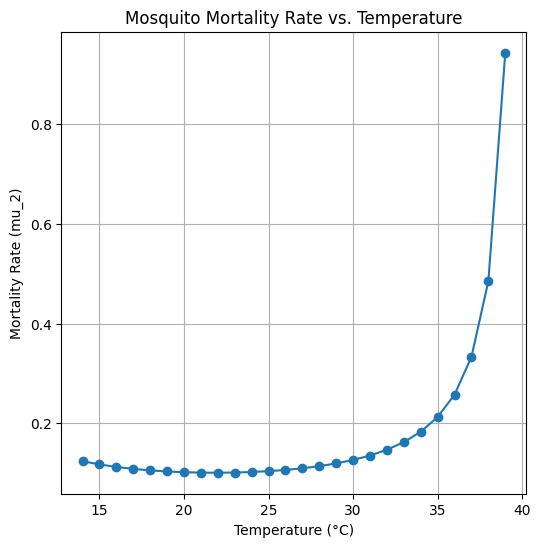

In [24]:
plt.figure(figsize=(6, 6))
plt.plot(temperatures, mu_2array, '-o')
plt.title('Mosquito Mortality Rate vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Mortality Rate (mu_2)')
plt.grid(True)
plt.show()